In [1]:
import pathlib

import numpy as np
import pandas as pd
import sklearn.ensemble
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
def oriented_neighbors(x, direction, axis):
    xp = np.pad(x, 1)
    neighbors = (xp + np.roll(xp, direction, axis=axis))[1:-1, 1:-1] == 2
    index = np.roll(neighbors, -direction, axis=axis)
    return index.flatten(), neighbors.flatten()

In [4]:
def plane_to_adjacency(x):
    adj = np.zeros((x.size, x.size))
    for direction, axis in [(1, 0), (-1, 0), (1, 1), (-1, 1)]:
        index, neighbors = oriented_neighbors(x, direction, axis)
        adj[index, neighbors] = 1
    return adj

In [5]:
def only_center_island(x):
    adjacency_matrix = plane_to_adjacency(x)
    graph = nx.from_numpy_matrix(adjacency_matrix)
    center = x.size // 2
    island = list(next(component for component in nx.connected_components(graph) if center in component))
    features = np.zeros(x.size, dtype=x.dtype)
    features[island] = 1
    return features.reshape(x.shape)

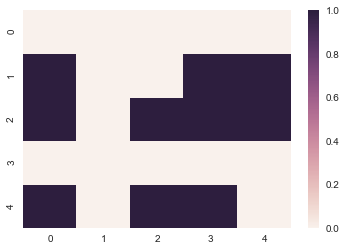

In [6]:
x = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
    [1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0],
])
sns.heatmap(x)

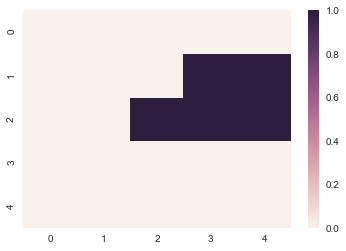

In [7]:
sns.heatmap(only_center_island(x))

In [8]:
def print_desks(desks):
    print("\n".join("".join(line) for line in desks))

In [11]:
text = pathlib.Path("dataset-train.txt").read_text()
desks_train = np.array([list(line) for line in text.splitlines()])
desks_train = np.pad(desks_train, 2, constant_values=".")

In [12]:
rotations = {"N": "W", "E": "N", "S": "E", "W": "S"}
horizontal_flips = {"N": "N", "E": "W", "S": "S", "W": "E"}
vertical_flips = {"N": "S", "E": "E", "S": "N", "W": "W"}


def simple_features(j, i, presence):
    return (
        presence[j-1, i],
        presence[j-1, i] and presence[j-2, i],
        presence[j, i+1],
        presence[j, i+1] and presence[j, i+2],
        presence[j+1, i],
        presence[j+1, i] and presence[j+2, i],
        presence[j, i-1],
        presence[j, i-1] and presence[j, i-2],
    )


def advanced_features(j, i, presence):
    neighborhood = presence[j-2:j+3, i-2:i+3]
    neighborhood = only_center_island(neighborhood)
    return tuple(neighborhood.flatten())


def augment_desks(desks):
    
    yield np.array([
        [horizontal_flips.get(value, value) for value in row] for row in np.flip(desks, axis=1)
    ])
    
    yield np.array([
        [vertical_flips.get(value, value) for value in row] for row in np.flip(desks, axis=0)
    ])
    
    
    for n in range(4):
        rotated_desks = desks
        for i in range(n):
            rotated_desks = np.array([
                [rotations.get(value, value) for value in row] for row in np.rot90(rotated_desks)
            ])
        yield rotated_desks

        
def floor_features(desks, get_features):
    def generate():
        desk_presence = (desks != ".").astype(int)
        for (j, i), y_true in np.ndenumerate(desks):
            if y_true == ".":
                continue

            yield (j, i), get_features(j, i, desk_presence), y_true

    coords, X, y = zip(*generate())
    j, i = zip(*coords)
    return (j, i), X, y


def fit(desks, get_features):
    model = {}
    undecidable = set()
    for augmented_desks in augment_desks(desks):
        desk_presence = (augmented_desks != ".").astype(int)
        for (j, i), y_true in np.ndenumerate(augmented_desks):
            if y_true == ".":
                continue
            x_train = get_features(j, i, desk_presence)
            try:
                if model[x_train] != y_true:
                    #print(pd.DataFrame(augmented_desks))
                    undecidable.add(x_train)
                    #print(f"Different y's ({model[x_train]}, {y_true}) for same x ({x_train}) at ({j}, {i})")
                    del model[x_train]
            except KeyError:
                if x_train not in undecidable:
                    model[x_train] = y_true
    return model

In [13]:
simple_model = fit(desks_train, simple_features)
len(simple_model)

24

In [14]:
intermediate_model = fit(desks_train, intermediate_features)
len(intermediate_model)

90

In [15]:
advanced_model = fit(desks_train, advanced_features)
len(advanced_model)

126

In [16]:
def fit_clf(desks, get_features):
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)

    X, y = [], []
    for augmented_desks in augment_desks(desks):
        desk_presence = (augmented_desks != ".").astype(int)

        for (j, i), y_true in np.ndenumerate(augmented_desks):
            if y_true == ".":
                continue
                
            X.append(get_features(j, i, desk_presence))
            y.append(y_true)

    clf.fit(X, y)
    
    return clf
    

ml_model = fit_clf(desks_train, advanced_features)

In [17]:
text = pathlib.Path("dataset-test.txt").read_text()
original_desks = np.array([list(line) for line in text.splitlines()])
original_desks = np.pad(original_desks, 2, constant_values=".")
desks_test = np.concatenate((
    original_desks,
    np.flip(original_desks, axis=1),
    np.flip(original_desks, axis=0),
    np.rot90(np.rot90(original_desks)),
), axis=1)
desks_test_2 = np.concatenate((
    np.rot90(original_desks),
    np.rot90(np.rot90(np.rot90(original_desks))),
), axis=0)

In [18]:
def predict_orientation(desks, model_name):
    desks_pred = np.array(desks)
    if model_name == "rf":
        coords, X, _ = floor_features(desks, advanced_features)
        y_pred = ml_model.predict(X)
        max_proba = ml_model.predict_proba(X).max(axis=1)
        y_pred[max_proba < 0.85] = "?"
    elif model_name == "simple":
        coords, X, _ = floor_features(desks, simple_features)
        y_pred = np.array([simple_model.get(x, "?") for x in X])
    elif model_name == "advanced":
        coords, X, _ = floor_features(desks, advanced_features)
        y_pred = np.array([advanced_model.get(x, "?") for x in X])
    elif model_name == "combined":
        x_simple = simple_features(j, i, desk_presence_test)
        x_advanced = advanced_features(j, i, desk_presence_test)
        y_pred = simple_model.get(x_simple) or advanced_model.get(x_advanced)
    desks_pred[coords] = y_pred
    return desks_pred

    
for name in ["simple", "advanced", "rf"]:
    desks_pred = predict_orientation(desks_test, name)[2:-2, 2:-2]
    pathlib.Path(f"pred-{name}.txt").write_text("\n".join("".join(line) for line in desks_pred))
    desks_pred = predict_orientation(desks_test_2, name)[2:-2, 2:-2]
    pathlib.Path(f"pred-{name}-horizontal.txt").write_text("\n".join("".join(line) for line in desks_pred))

In [10]:
cd desk-orientation

/Users/axel/PycharmProjects/desk-orientation
